# Part IV (Decompounded Options)
We start by importing the following modules needed for our computation:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

Additionally, we recall the following definitions from part 3:

In [2]:
def IRR_0(K, m, N):
    value = 1/K * (1 - 1/(1 + K/m)**(N * m))
    return value

def IRR_1(K, m, N):
    firstDerivative = -1/K * IRR_0(K, m, N) + 1/(K * m) * N * m/(1 + K/m)**(N * m + 1)
    return firstDerivative

def IRR_2(K, m, N):
    secondDerivative = -2/K * IRR_1(K, m, N) - 1/(K * m**2)*(N * m)*(N * m + 1)/(1 + K/m)**(N * m + 2)
    return secondDerivative

Since $g(F) = F^\frac{1}{p} - 0.04^\frac{1}{q}$ with $p = 4, q = 2$, we obtain the following derivatives:
\begin{equation*}
\begin{split}
g(K) &= K^\frac{1}{4} - 0.04^\frac{1}{2},\,\,g'(K) &= \frac{1}{4}K^{-\frac{3}{4}},\,\,g''(K) &= -\frac{3}{16}K^{-\frac{7}{4}}.
\end{split}
\end{equation*}

In [3]:
def g_0(K):
    return K**(1/4) - 0.04**(1/2)

def g_1(K):
    return (1/4) * K**(-3/4)

def g_2(K):
    return (-3/16) * K**(-7/4)

def h_0(K, m, N):
    value = g_0(K) / IRR_0(K, m, N)
    return value

def h_1(K, m, N):
    firstDerivative = (IRR_0(K, m, N) * g_1(K) - g_0(K) * IRR_1(K, m, N)) / IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, m, N):
    secondDerivative = ((IRR_0(K, m, N) * g_2(K) - IRR_2(K, m, N) * g_0(K) - 2.0 * IRR_1(K, m, N) * g_1(K))/IRR_0(K, m, N)**2 
                        + 2 * IRR_1(K, m, N)**2 * g_0(K)/IRR_0(K, m, N)**3)
    return secondDerivative

def Black76Call(F, K, sigma, T):
    d1 = (np.log(F/K) + (sigma**2) * T/2)/(sigma * np.sqrt(T))
    d2 = (np.log(F/K) - (sigma**2) * T/2)/(sigma * np.sqrt(T))
    return (F * norm.cdf(d1) - K * norm.cdf(d2))

def Black76Put(F, K, sigma, T):
    d1 = (np.log(F/K) + (sigma**2) * T/2)/(sigma * np.sqrt(T))
    d2 = (np.log(F/K) - (sigma**2) * T/2)/(sigma * np.sqrt(T))
    return (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

def payer_swaption(discount, F, K, sigma, T, m , N):
    return discount * IRR_0(F, m, N) * Black76Call(F, K, sigma, T)

def receiver_swaption(discount, F, K, sigma, T, m , N):
    return discount * IRR_0(F, m, N) * Black76Put(F, K, sigma, T)

def call_integrand(discount, F, K, sigma, T, m , N):
    price = h_2(K, m, N) * payer_swaption(discount, F, K, sigma, T, m , N)
    return price

def put_integrand(discount, F, K, sigma, T, m , N):
    price = h_2(K, m, N) * receiver_swaption(discount, F, K, sigma, T, m , N)
    return price

## Questions
1. A decompounded option pays the following at time $T = 5y$:
$$
\text{(CMS $10y$)}^{1/p} - 0.04^{1/q},
$$
where $p = 4$ and $q = 2$. Use static replication to value the PV of this payoff.

In [4]:
params_df = pd.read_csv("calibrated_params.csv")
discount_factor_df = pd.read_csv("discount_factors.csv")

par_swap_df = pd.read_csv("par_swap_rate.csv")
par_swap_df.set_index('Unnamed: 0', inplace=True)
par_swap_df = par_swap_df.T.unstack().reset_index(name='Swap_Rate')
par_swap_df.columns = ["Expiry", "Tenor", "Swap_Rate"]

# Input parameters here
T = 5
N = 10
m = 2
discount = discount_factor_df[(discount_factor_df.Tenor == 5)]["OIS discount factor"].iloc[0]
F = par_swap_df[(par_swap_df.Expiry == '5Y') & (par_swap_df.Tenor == '10Y')]['Swap_Rate'].iloc[0]

alpha = params_df[(params_df.Expiry == '5Y') & (params_df.Tenor == '10Y')]['Alpha'].iloc[0]
rho = params_df[(params_df.Expiry == '5Y') & (params_df.Tenor == '10Y')]['Rho'].iloc[0]
nu = params_df[(params_df.Expiry == '5Y') & (params_df.Tenor == '10Y')]['Nu'].iloc[0]
beta = 0.9

I_put = quad(lambda x: put_integrand(discount, F, x, SABR(F,x,T, alpha=alpha, beta=beta, rho=rho, nu=nu), T, m , N), 0.0, F)
I_call = quad(lambda x: call_integrand(discount, F, x, SABR(F,x,T, alpha=alpha, beta=beta, rho=rho, nu=nu), T, m , N), F, 5000)

v_0 = discount * g_0(F) + I_put[0] + I_call[0]

print(f"The PV of the payoff of the decompounded option in part 1 is: {v_0}")

The PV of the payoff of the decompounded option in part 1 is: 0.23339499426083823


2. Suppose the payoff is now
$$
\left(\text{(CMS $10y$)}^{1/p} - 0.04^{1/q}\right)^+.
$$
Use static replication to value the PV of this payoff.

In [5]:
L = (0.04 **(1/2))**4
I_call2 = quad(lambda x: call_integrand(discount, F, x, SABR(F,x,T, alpha=alpha, beta=beta, rho=rho, nu=nu), T, m , N), L, 5000)
v_1 = h_1(L, m, N) * payer_swaption(discount, F, L, SABR(F,L,T, alpha=alpha, beta=beta, rho=rho, nu=nu), T, m, N) + I_call2[0]

print(f"The PV of the payoff of the decompounded option in part 2 is: {v_1}")

The PV of the payoff of the decompounded option in part 2 is: 0.25144601726342575


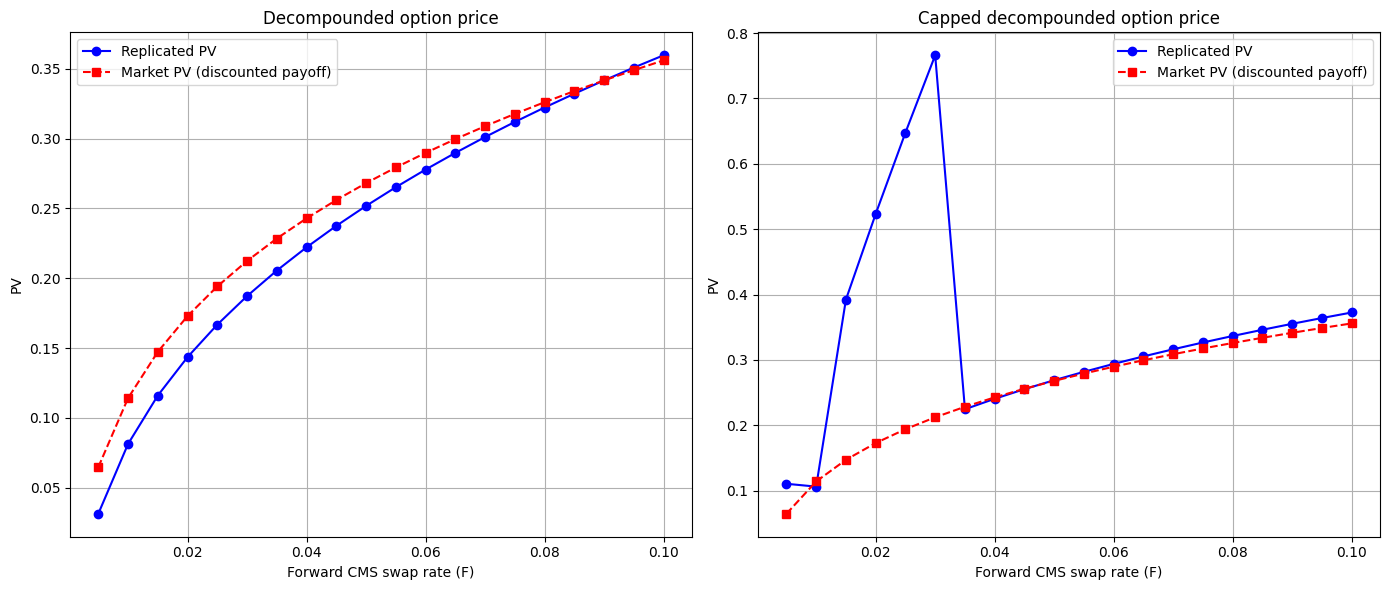

In [6]:
# --- Define pricing functions as functions of F ---
def replication_price_decompounded(F):
    # For the decompounded option with payoff: (CMS 10y)^(1/4) - 0.04^(1/2)
    I_put = quad(lambda x: put_integrand(discount, F, x, SABR(F, x, T, alpha, beta, rho, nu), T, m, N), 0.0, F)[0]
    I_call = quad(lambda x: call_integrand(discount, F, x, SABR(F, x, T, alpha, beta, rho, nu), T, m, N), F, 5000)[0]
    return discount * g_0(F) + I_put + I_call

def market_price_decompounded(F):
    # Here the "market" price is taken as the discounted direct payoff
    return discount * (F**(1/4) - 0.04**(1/2))

def replication_price_decompounded_call(F):
    # For the capped decompounded option payoff: ((CMS 10y)^(1/4) - 0.04^(1/2))^+
    L = (0.04**(1/2))**4
    I_call2 = quad(lambda x: call_integrand(discount, F, x, SABR(F, x, T, alpha, beta, rho, nu), T, m, N), L, 5000)[0]
    return h_1(L, m, N) * payer_swaption(discount, F, L, SABR(F, L, T, alpha, beta, rho, nu), T, m, N) + I_call2

def market_price_decompounded_call(F):
    payoff = max(F**(1/4) - 0.04**(1/2), 0)
    return discount * payoff

# --- Create a grid for the forward swap rate ---
F_values = np.linspace(0.005, 0.1, 20)

# Initialize arrays to store computed prices:
rep_price = []
mkt_price = []
rep_price_call = []
mkt_price_call = []

# Note: Each integration can be a little computationally heavy
for F in F_values:
    rep_price.append(replication_price_decompounded(F))
    mkt_price.append(market_price_decompounded(F))
    rep_price_call.append(replication_price_decompounded_call(F))
    mkt_price_call.append(market_price_decompounded_call(F))

# --- Plotting the results ---
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Left plot: uncapped decompounded option
axes[0].plot(F_values, rep_price, 'b-o', label='Replicated PV')
axes[0].plot(F_values, mkt_price, 'r--s', label='Market PV (discounted payoff)')
axes[0].set_title('Decompounded option price')
axes[0].set_xlabel('Forward CMS swap rate (F)')
axes[0].set_ylabel('PV')
axes[0].legend()
axes[0].grid(True)

# Right plot: capped decompounded option
axes[1].plot(F_values, rep_price_call, 'b-o', label='Replicated PV')
axes[1].plot(F_values, mkt_price_call, 'r--s', label='Market PV (discounted payoff)')
axes[1].set_title('Capped decompounded option price')
axes[1].set_xlabel('Forward CMS swap rate (F)')
axes[1].set_ylabel('PV')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()